In [8]:
import pandas as pd
import logging
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Flatten, Conv1D, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
from tqdm.notebook import tqdm
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [3]:

def load_data(file_name):
    return pd.read_csv(file_name)

# Load all datasets
main = load_data("partograph-main.csv")

datasets = ["contraction", "dilatation", "fhr", "bp", "amniotic", "urine", "headdescent", "pulse", "moulding", "temperature", "baby"]
dataframes = [load_data(f"partograph-{dataset}.csv") for dataset in datasets]
# .drop(columns=['DATE'])
# # Merge datasets
merged = main
for df, dataset in zip(dataframes, datasets):
    merged = pd.merge(merged, df, how='inner', left_on='KEY', right_on=f'KEY_{dataset.upper()}')
# 
merged = merged.drop(columns=['EDD'])

merged

,KEY,DATE,AGE,GRAVIDA,PARITY,GESTATIONAL_AGE,RUPTURED_MEMBRANE,ESTIMATED_BLOOD_LOST,COMPLICATIONS,MATERNAL_COMPLICATION,...,DATE_TEMPERATURE,VALUE_TEMPERATURE,KEY_BABY,DATE_DELIVERY,PLACENTA_DELIVERY_DATE,WEIGHT,HEAD_CIRCUMFERENCE,FULL_LENGTH,APGAR_1,APGAR_2
0,106,2023-02-07,33,3,0,40,0,150,0,0,...,7/2/23 8:00,36.400002,106,2023/07/02 09:53,2023/07/02 10:00,3.3,33,43,7,8
1,106,2023-02-07,33,3,0,40,0,150,0,0,...,7/2/23 8:00,36.400002,106,2023/07/02 09:53,2023/07/02 10:00,3.3,33,43,7,8
2,106,2023-02-07,33,3,0,40,0,150,0,0,...,7/2/23 8:00,36.400002,106,2023/07/02 09:53,2023/07/02 10:00,3.3,33,43,7,8
3,106,2023-02-07,33,3,0,40,0,150,0,0,...,7/2/23 8:00,36.400002,106,2023/07/02 09:53,2023/07/02 10:00,3.3,33,43,7,8
4,106,2023-02-07,33,3,0,40,0,150,0,0,...,7/2/23 8:00,36.400002,106,2023/07/02 09:53,2023/07/02 10:00,3.3,33,43,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150011,88,2023-07-20,32,2,4,40,1,170,1,1,...,7/20/23 18:00,36.400002,88,2023/07/20 20:10,2023/07/20 20:10,3.2,32,50,8,9
150012,88,2023-07-20,32,2,4,40,1,170,1,1,...,7/20/23 18:00,36.400002,88,2023/07/20 20:10,2023/07/20 20:10,3.2,32,50,8,9
150013,88,2023-07-20,32,2,4,40,1,170,1,1,...,7/20/23 18:00,36.400002,88,2023/07/20 20:10,2023/07/20 20:10,3.2,32,50,8,9
150014,88,2023-07-20,32,2,4,40,1,170,1,1,...,7/20/23 18:00,36.400002,88,2023/07/20 20:10,2023/07/20 20:10,3.2,32,50,8,9


In [4]:

# Reorder columns for better readability
column_order = ['VALUE_CONTRACTION', 'INTENSITY', 'VALUE_DILATATION', 'VALUE_FHR', 'DIASTOLIC', 'SYSTOLIC', 'VALUE_AMNIOTIC', 'PROTIEN', 
                'ACETONE', 'VOLUME', 'VALUE_HEADDESCENT', 'VALUE_PULSE', 'VALUE_MOULDING', 'VALUE_TEMPERATURE', 'WEIGHT', 'HEAD_CIRCUMFERENCE', 
                'FULL_LENGTH', 'APGAR_1', 'APGAR_2', 'AGE', 'GRAVIDA', 'PARITY', 'GESTATIONAL_AGE', 'RUPTURED_MEMBRANE', 'ESTIMATED_BLOOD_LOST', 
                'COMPLICATIONS', 'MATERNAL_COMPLICATION', 'FETAL_COMPLICATION', 'PRECIPITOUS_LABOUR', 'PERINEAL_TEAR', 'POST_PARTUM_HEMORRHAGE', 
                'PROLONGED_LABOUR', 'PRE_ECLAMPSIA', 'RETAINED_PLACENTA', 'ARREST_OF_DESCENT', 'ARREST_OF_DILATATION', 'BIRTH_ASPHYSIA', 
                'FETAL_DISTRESS', 'DATE_CONTRACTION', 'DATE_DILATATION', 'DATE_FHR', 'DATE_BP', 'DATE_AMNIOTIC', 'DATE_URINE', 'DATE_PULSE', 
                'DATE_MOULDING', 'DATE_HEADDESCENT', 'DATE_DELIVERY', 'DATE_TEMPERATURE', 'PLACENTA_DELIVERY_DATE', 'DATE']
merged = merged[column_order]


In [5]:

df = merged.copy()

In [6]:

df = df.drop(columns=['DATE_CONTRACTION', 'DATE_DILATATION', 'DATE_FHR', 'DATE_BP', 'DATE_AMNIOTIC', 'DATE_URINE', 'DATE_PULSE', 
                      'DATE_MOULDING', 'DATE_HEADDESCENT', 'DATE_DELIVERY', 'DATE_TEMPERATURE', 'PLACENTA_DELIVERY_DATE', 'DATE'])
df

,VALUE_CONTRACTION,INTENSITY,VALUE_DILATATION,VALUE_FHR,DIASTOLIC,SYSTOLIC,VALUE_AMNIOTIC,PROTIEN,ACETONE,VOLUME,...,PRECIPITOUS_LABOUR,PERINEAL_TEAR,POST_PARTUM_HEMORRHAGE,PROLONGED_LABOUR,PRE_ECLAMPSIA,RETAINED_PLACENTA,ARREST_OF_DESCENT,ARREST_OF_DILATATION,BIRTH_ASPHYSIA,FETAL_DISTRESS
0,3,2,4,140,83,103,3,1,1,402,...,0,0,0,0,0,0,0,0,0,0
1,3,2,4,140,83,103,3,1,1,402,...,0,0,0,0,0,0,0,0,0,0
2,3,2,4,140,83,103,3,1,1,402,...,0,0,0,0,0,0,0,0,0,0
3,3,2,4,140,83,103,3,1,1,402,...,0,0,0,0,0,0,0,0,0,0
4,3,2,4,140,83,103,3,1,1,402,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150011,3,3,10,140,63,108,1,1,1,402,...,1,0,0,0,0,0,0,0,0,0
150012,3,3,10,140,63,108,3,1,1,402,...,1,0,0,0,0,0,0,0,0,0
150013,3,3,10,140,63,108,3,1,1,402,...,1,0,0,0,0,0,0,0,0,0
150014,3,3,10,140,63,108,3,1,1,402,...,1,0,0,0,0,0,0,0,0,0


In [7]:
# Fill NaN values with mean
df.fillna(df.mean(), inplace=True)
df

,VALUE_CONTRACTION,INTENSITY,VALUE_DILATATION,VALUE_FHR,DIASTOLIC,SYSTOLIC,VALUE_AMNIOTIC,PROTIEN,ACETONE,VOLUME,...,PRECIPITOUS_LABOUR,PERINEAL_TEAR,POST_PARTUM_HEMORRHAGE,PROLONGED_LABOUR,PRE_ECLAMPSIA,RETAINED_PLACENTA,ARREST_OF_DESCENT,ARREST_OF_DILATATION,BIRTH_ASPHYSIA,FETAL_DISTRESS
0,3,2,4,140,83,103,3,1,1,402,...,0,0,0,0,0,0,0,0,0,0
1,3,2,4,140,83,103,3,1,1,402,...,0,0,0,0,0,0,0,0,0,0
2,3,2,4,140,83,103,3,1,1,402,...,0,0,0,0,0,0,0,0,0,0
3,3,2,4,140,83,103,3,1,1,402,...,0,0,0,0,0,0,0,0,0,0
4,3,2,4,140,83,103,3,1,1,402,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150011,3,3,10,140,63,108,1,1,1,402,...,1,0,0,0,0,0,0,0,0,0
150012,3,3,10,140,63,108,3,1,1,402,...,1,0,0,0,0,0,0,0,0,0
150013,3,3,10,140,63,108,3,1,1,402,...,1,0,0,0,0,0,0,0,0,0
150014,3,3,10,140,63,108,3,1,1,402,...,1,0,0,0,0,0,0,0,0,0


In [9]:
# Assuming multi-label classification, choose multiple columns from Y

target_columns = ['PRECIPITOUS_LABOUR', 'PERINEAL_TEAR', 'POST_PARTUM_HEMORRHAGE', 'PROLONGED_LABOUR', 'PRE_ECLAMPSIA', 'RETAINED_PLACENTA',
                 'ARREST_OF_DESCENT', 'ARREST_OF_DILATATION', 'BIRTH_ASPHYSIA', 'FETAL_DISTRESS'] 

# Encode class values as integers for each column
encoded_Y_list = []
for col in target_columns:
    encoder = LabelEncoder()
    encoded_Y_list.append(encoder.fit_transform(df[col]))

# Concatenate the encoded columns
encoded_Y = pd.DataFrame(np.column_stack(encoded_Y_list), columns=target_columns)

# Assuming X contains your features, adjust as needed
X = df.iloc[:, 0:28].astype(float)

# Use TimeSeriesSplit for time-series cross-validation
tscv = TimeSeriesSplit(n_splits=10)

tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)

In [16]:

def create_mlp_model(input_shape, output_shape):
    input_layer = Input(shape=(input_shape,))
    hidden1 = Dense(128, activation='relu')(input_layer)
    dropout1 = Dropout(0.5)(hidden1) 
    hidden2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(hidden2) 
    hidden3 = Dense(32, activation='sigmoid')(dropout2)
    output_layer = Dense(output_shape, activation='sigmoid')(hidden3)

    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=['accuracy'])
    return model

def create_lstm_model(input_shape, output_shape):
    model = keras.models.Sequential()
    model.add(LSTM(128, input_shape=(input_shape, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_shape, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=['accuracy'])
    return model

def create_cnn_model(input_shape, output_shape):
    model = keras.models.Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(input_shape, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_shape, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=['accuracy'])
    return model

def create_fcnn_model(input_shape, output_shape):
    model = keras.models.Sequential()
    model.add(Dense(128, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dense(output_shape, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=['accuracy'])
    return model

In [17]:

# Construct pipeline
def create_pipeline(model):
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', KerasClassifier(model=model, epochs=16, batch_size=5, validation_split=0.2, verbose=0)))
    pipeline = Pipeline(estimators)
    return pipeline


In [19]:
from sklearn.metrics import accuracy_score


try:
    for model_type, create_model in [('MLP', create_mlp_model), ('LSTM', create_lstm_model), ('CNN', create_cnn_model), ('FCNN', create_fcnn_model)]:
        print(f"Training and evaluating {model_type} model:")
        
        model = create_model(input_shape=X.shape[1], output_shape=len(target_columns))
        pipeline = create_pipeline(model)

        # Initialize lists to store evaluation metrics across folds
        precision_list, recall_list, f1_score_list, auc_roc_list, accuracy_list = [], [], [], [], []

        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = encoded_Y.iloc[train_index], encoded_Y.iloc[test_index]

            pipeline.fit(X_train, y_train)

            # Additional evaluation metrics on the test set
            y_pred = pipeline.predict(X_test)
            y_pred_proba = pipeline.predict_proba(X_test)

            # Calculate evaluation metrics for each target column
            for i, col in enumerate(target_columns):
                precision = precision_score(y_test[col], y_pred[:, i], zero_division=1)
                recall = recall_score(y_test[col], y_pred[:, i], zero_division=1)
                f1 = f1_score(y_test[col], y_pred[:, i], zero_division=1)

                precision_list.append(precision)
                recall_list.append(recall)
                f1_score_list.append(f1)

                try:
                    auc_roc = roc_auc_score(y_test[col], y_pred_proba[:, i])
                    auc_roc_list.append(auc_roc)
                except ValueError as ve:
                    pass

            # Calculate accuracy and store it in the list
            accuracy = accuracy_score(y_test, y_pred)
            accuracy_list.append(accuracy)
            print(f"{train_index} Accuracy : {accuracy}")

        # Average metrics across folds
        avg_precision = sum(precision_list) / len(precision_list)
        avg_recall = sum(recall_list) / len(recall_list)
        avg_f1_score = sum(f1_score_list) / len(f1_score_list)
        avg_accuracy = sum(accuracy_list) / len(accuracy_list)

        if auc_roc_list:
            avg_auc_roc = sum(auc_roc_list) / len(auc_roc_list)
            print(f"Average AUC-ROC : {avg_auc_roc}")

        print(f"Average Accuracy : {avg_accuracy}")
        print(f"Average Precision : {avg_precision}")
        print(f"Average Recall : {avg_recall}")
        print(f"Average F1-Score : {avg_f1_score}")

except Exception as e:
    logger.error(f"Error during cross-validation or training: {e}")

Training and evaluating MLP model:
[    0     1     2 ... 13643 13644 13645] Accuracy : 0.9420693700960622
[    0     1     2 ... 27280 27281 27282] Accuracy : 1.0
[    0     1     2 ... 40917 40918 40919] Accuracy : 1.0
[    0     1     2 ... 54554 54555 54556] Accuracy : 1.0
[    0     1     2 ... 68191 68192 68193] Accuracy : 1.0
[    0     1     2 ... 81828 81829 81830] Accuracy : 1.0
[    0     1     2 ... 95465 95466 95467] Accuracy : 1.0
[     0      1      2 ... 109102 109103 109104] Accuracy : 1.0
[     0      1      2 ... 122739 122740 122741] Accuracy : 1.0
[     0      1      2 ... 136376 136377 136378] Accuracy : 0.7264794309598885
Average AUC-ROC : 0.7218770257598658
Average Accuracy : 0.9668548801055952
Average Precision : 0.997871175838139
Average Recall : 0.9795711187856397
Average F1-Score : 0.9785896547189432
Training and evaluating LSTM model:
[    0     1     2 ... 13643 13644 13645] Accuracy : 0.5988853853486837
[    0     1     2 ... 27280 27281 27282] Accuracy :

In [20]:
from sklearn.metrics import classification_report

try:
    y_pred_classes = (y_pred > 0.5).astype(int)

    classification_rep = classification_report(y_test, y_pred_classes, target_names=target_columns, zero_division=1)
    print("Classification Report on Test Set:\n%s" % classification_rep)

except Exception as e:
    logger.error(f"Error during cross-validation or training: {e}")

Classification Report on Test Set:
                        precision    recall  f1-score   support

    PRECIPITOUS_LABOUR       1.00      0.09      0.16      1552
         PERINEAL_TEAR       1.00      1.00      1.00         0
POST_PARTUM_HEMORRHAGE       1.00      1.00      1.00         0
      PROLONGED_LABOUR       1.00      1.00      1.00         0
         PRE_ECLAMPSIA       1.00      1.00      1.00         0
     RETAINED_PLACENTA       1.00      1.00      1.00         0
     ARREST_OF_DESCENT       1.00      1.00      1.00         0
  ARREST_OF_DILATATION       1.00      1.00      1.00         0
        BIRTH_ASPHYSIA       1.00      1.00      1.00      8053
        FETAL_DISTRESS       1.00      1.00      1.00         0

             micro avg       1.00      0.85      0.92      9605
             macro avg       1.00      0.91      0.92      9605
          weighted avg       1.00      0.85      0.86      9605
           samples avg       1.00      0.90      0.90      9605



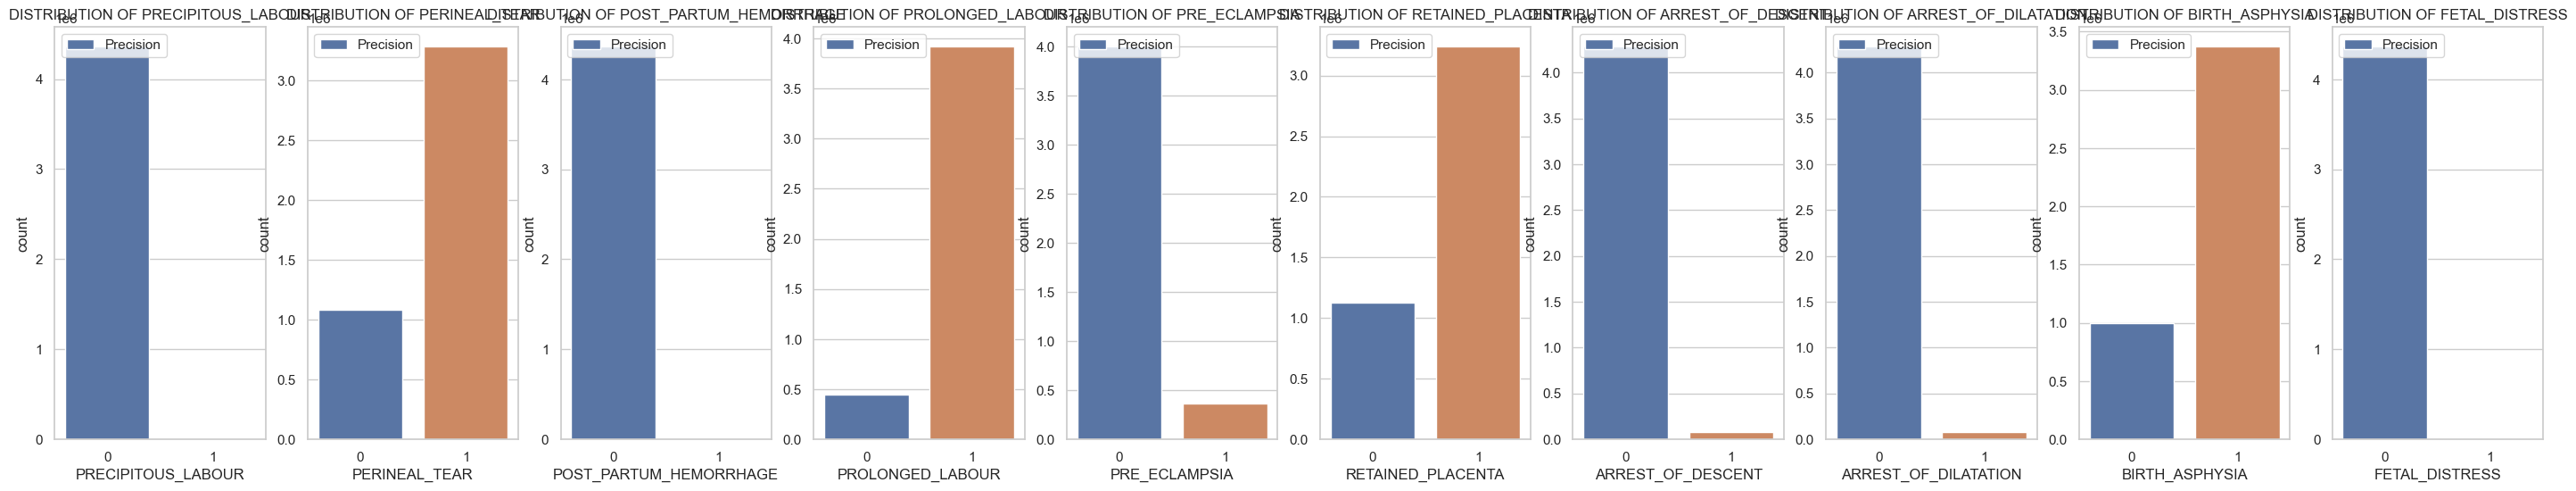

In [10]:

# 1. Distribution of Target Variables
sns.set(style="whitegrid")
plt.figure(figsize=(36, 6))
for i, col in enumerate(target_columns, 1):
    plt.subplot(1, len(target_columns), i)
    sns.countplot(data=df, x=col)
    plt.title(f'DISTRIBUTION OF {col}')
    plt.legend(['Precision', 'Recall', 'F1-Score'], loc='upper left')
    
plt.show()


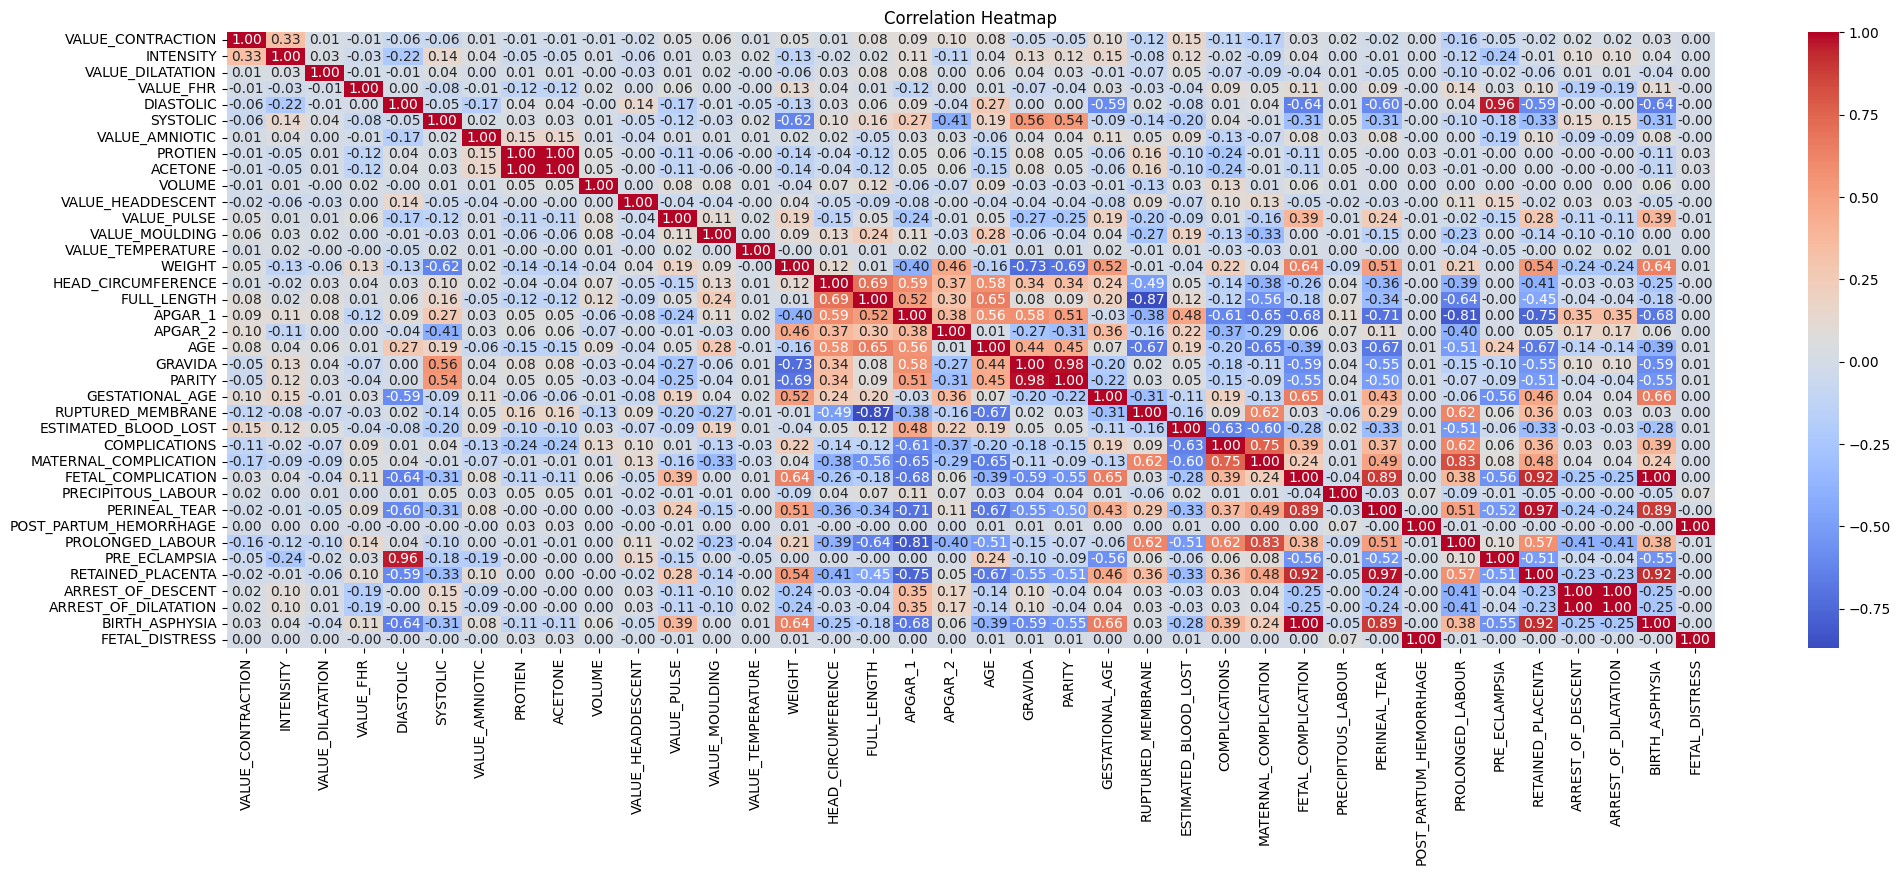

In [26]:

# # 2. Correlation Heatmap
plt.figure(figsize=(24, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
df.corr().describe().to_string()
plt.title('Correlation Heatmap')
plt.show()


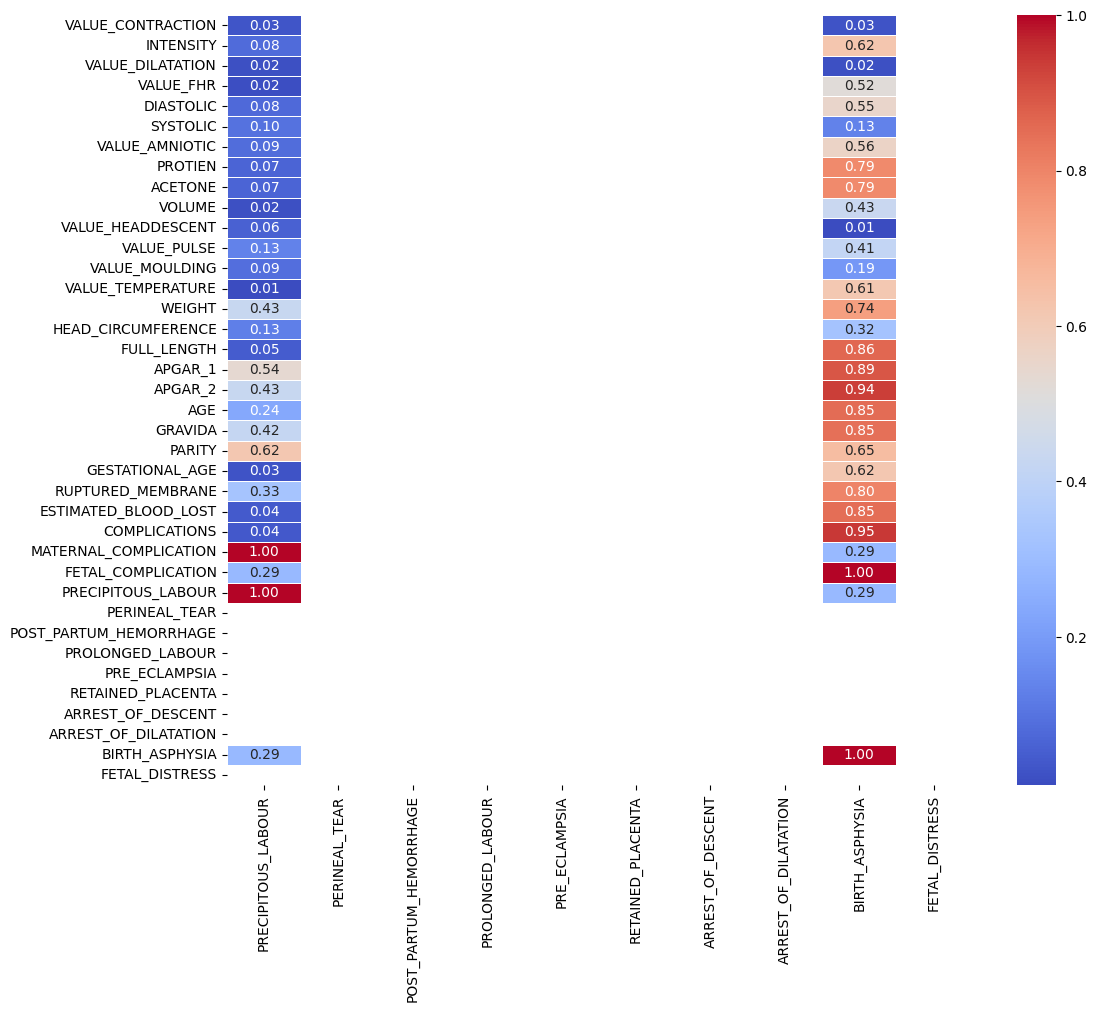

In [21]:
correlation_with_target = df.corr()[target_columns].abs()

df.corr()[target_columns].describe().to_string()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_with_target, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.show()

<bound method NDFrame.describe of     Precision  Recall  F1-Score
0         1.0     0.0       0.0
1         1.0     1.0       1.0
2         1.0     1.0       1.0
3         1.0     1.0       1.0
4         1.0     1.0       1.0
..        ...     ...       ...
95        1.0     1.0       1.0
96        1.0     1.0       1.0
97        1.0     1.0       1.0
98        1.0     1.0       1.0
99        1.0     1.0       1.0

[100 rows x 3 columns]>


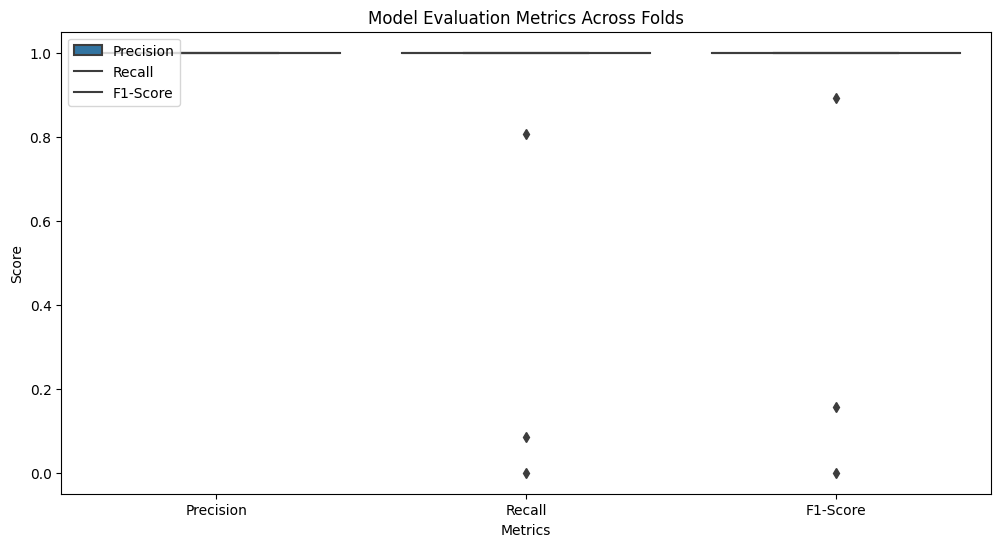

In [22]:

# 3. Model Evaluation Metrics
metrics_df = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-Score': f1_score_list
    # ,
    # 'AUC-ROC': auc_roc_list
})

print(metrics_df.describe)

plt.figure(figsize=(12, 6))
sns.boxplot(data=metrics_df)
plt.title('Model Evaluation Metrics Across Folds')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.legend(['Precision', 'Recall', 'F1-Score'], loc='upper left')


427/427 [==============================] - 1s 2ms/step


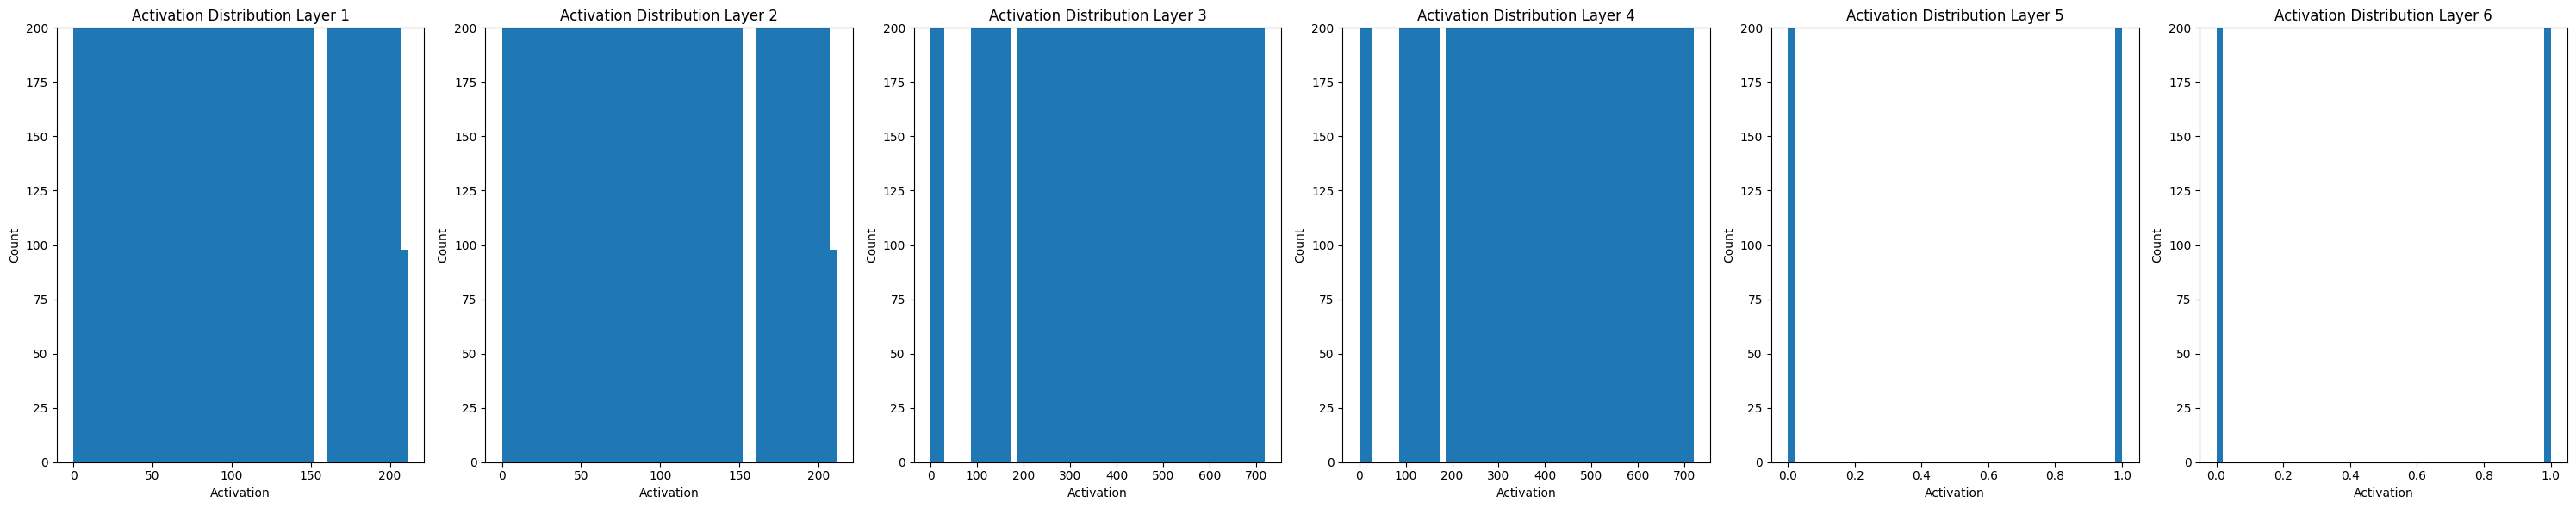

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Get activations from each layer
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(X_test)

# Plot distribution of activations
fig, axs = plt.subplots(1, len(activations), figsize=(30, 6))

for i, activation in enumerate(activations):
    axs[i].hist(activation.flatten(), bins=50)
    axs[i].set_title('Activation Distribution Layer {}'.format(i+1))
    axs[i].set_ylim(top=200) # Set consistent y-axis limit
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel('Activation')

plt.tight_layout()
plt.show()

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Maternal age
maternal_age_stats = merged['AGE'].describe()
print(maternal_age_stats)
maternal_age_mean = maternal_age_stats['mean']
maternal_age_std = maternal_age_stats['std']
maternal_age_range = maternal_age_stats['min'], maternal_age_stats['max']

# Gravida: Mean
gravida_mean = merged['GRAVIDA'].mean()
# print(gravida_mean)

# Parity: Mean
parity_mean = merged['PARITY'].mean()
# print(parity_mean)

# Gestational age: Average
gestational_age_mean = merged['GESTATIONAL_AGE'].mean()
# print(gestational_age_mean)

# Adverse outcomes
adverse_outcomes_columns = ['PRECIPITOUS_LABOUR', 'PERINEAL_TEAR', 'POST_PARTUM_HEMORRHAGE',
                            'PROLONGED_LABOUR', 'RETAINED_PLACENTA', 'PRE_ECLAMPSIA', 'ARREST_OF_DESCENT',
                            'ARREST_OF_DILATATION', 'BIRTH_ASPHYSIA', 'FETAL_DISTRESS']

adverse_outcomes_stats = merged[adverse_outcomes_columns].describe()
print(adverse_outcomes_stats)


count    150016.000000
mean         36.487095
std           4.191598
min          20.000000
25%          38.000000
50%          38.000000
75%          38.000000
max          38.000000
Name: AGE, dtype: float64
       PRECIPITOUS_LABOUR  PERINEAL_TEAR  POST_PARTUM_HEMORRHAGE  \
count       150016.000000       150016.0                150016.0   
mean             0.012052            0.0                     0.0   
std              0.109119            0.0                     0.0   
min              0.000000            0.0                     0.0   
25%              0.000000            0.0                     0.0   
50%              0.000000            0.0                     0.0   
75%              0.000000            0.0                     0.0   
max              1.000000            0.0                     0.0   

       PROLONGED_LABOUR  RETAINED_PLACENTA  PRE_ECLAMPSIA  ARREST_OF_DESCENT  \
count          150016.0           150016.0       150016.0           150016.0   
mean             

In [ ]:

# Plotting the distribution of maternal age
plt.figure(figsize=(12, 6))
sns.histplot(merged['AGE'], bins=30, kde=True)
plt.title('Distribution of Maternal Age')
plt.xlabel('Maternal Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:

# Plotting the distribution of maternal age
plt.figure(figsize=(12, 6))
sns.histplot(merged['GRAVIDA'], bins=30, kde=True)
plt.title('Distribution of Gravida')
plt.xlabel('Gravida')
plt.ylabel('Frequency')
plt.show()

In [ ]:

# Plotting the distribution of maternal age
plt.figure(figsize=(12, 6))
sns.histplot(merged['PARITY'], bins=30, kde=True)
plt.title('Distribution of Parity')
plt.xlabel('Parity')
plt.ylabel('Frequency')
plt.show()

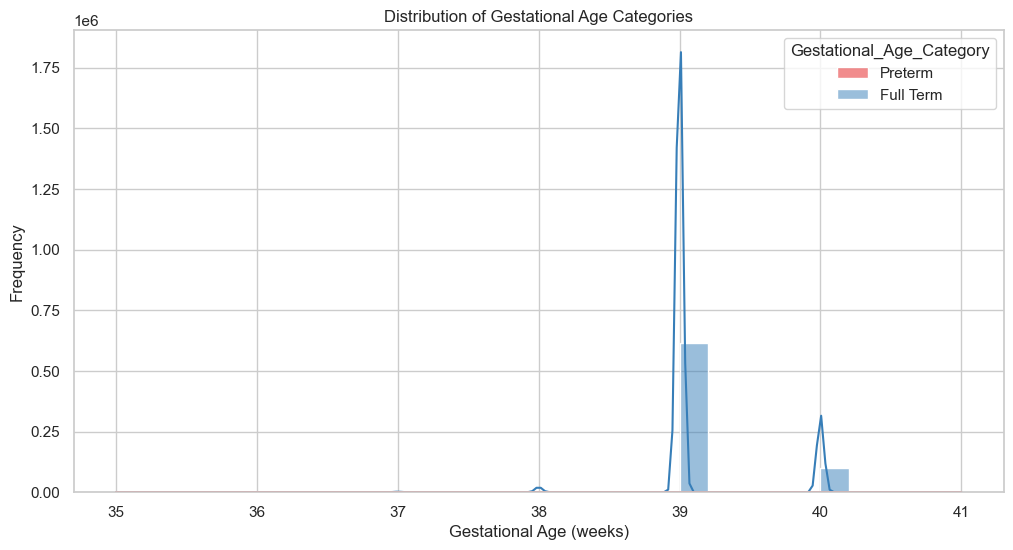

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting Gestational age with categories

# Create a new column indicating the gestational age category
merged['Gestational_Age_Category'] = pd.cut(merged['GESTATIONAL_AGE'], bins=[0, 36, float('inf')], labels=['Preterm', 'Full Term'])

# Set up the plot
plt.figure(figsize=(12, 6))
sns.histplot(data=merged, x='GESTATIONAL_AGE', hue='Gestational_Age_Category', bins=30, kde=True, palette='Set1')

# Adding labels and title
plt.title('Distribution of Gestational Age Categories')
plt.xlabel('Gestational Age (weeks)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

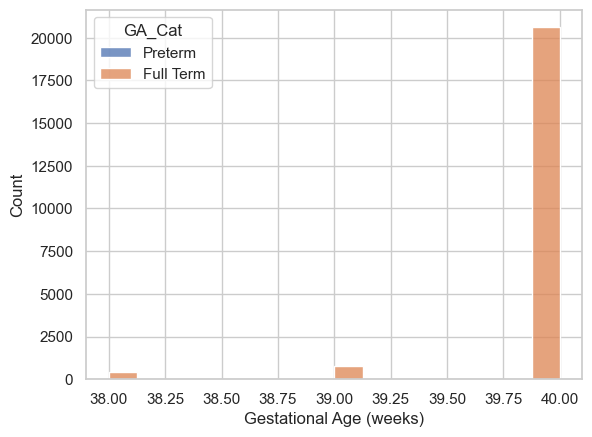

In [45]:
merged['GA_Cat'] = pd.cut(merged['GESTATIONAL_AGE'], bins=[0, 36, merged['GESTATIONAL_AGE'].max()], 
                      labels=['Preterm','Full Term'])
sns.histplot(data=merged, x='GESTATIONAL_AGE', hue='GA_Cat', multiple='stack')
plt.xlabel('Gestational Age (weeks)'); 

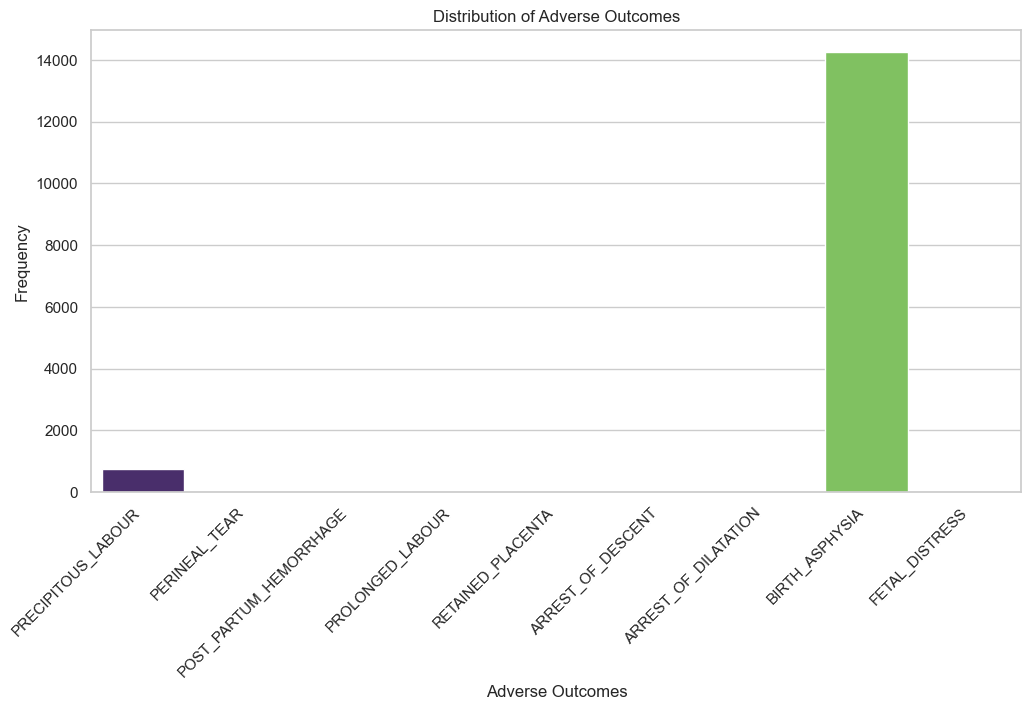

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Adverse outcomes columns
adverse_outcomes_columns = ['PRECIPITOUS_LABOUR', 'PERINEAL_TEAR', 'POST_PARTUM_HEMORRHAGE',
                            'PROLONGED_LABOUR', 'RETAINED_PLACENTA', 'ARREST_OF_DESCENT',
                            'ARREST_OF_DILATATION', 'BIRTH_ASPHYSIA', 'FETAL_DISTRESS']

# Count the occurrences of each adverse outcome
adverse_outcomes_counts = merged[adverse_outcomes_columns].sum()

# Plotting the distribution of adverse outcomes
plt.figure(figsize=(12, 6))
sns.barplot(x=adverse_outcomes_counts.index, y=adverse_outcomes_counts.values, palette='viridis')
plt.title('Distribution of Adverse Outcomes')
plt.xlabel('Adverse Outcomes')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()


count    721195.000000
mean        139.830284
std          16.580625
min          13.000000
25%         138.000000
50%         140.000000
75%         143.000000
max        1409.000000
Name: VALUE_FHR, dtype: float64


Text(-17.305555555555557, 0.5, 'Density')

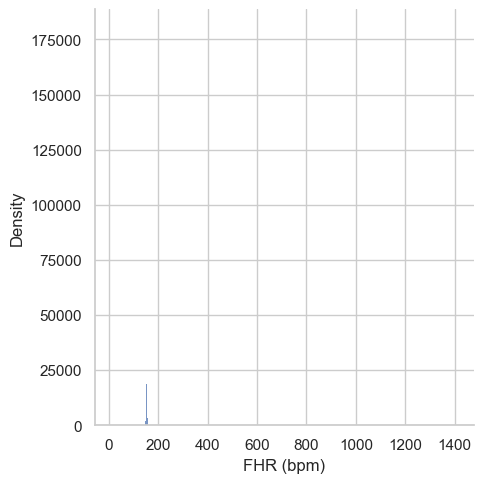

In [18]:
print(merged['VALUE_FHR'].describe())
sns.displot(merged['VALUE_FHR'])
plt.xlabel('FHR (bpm)'); plt.ylabel('Density')

             APGAR_1        APGAR_2
count  721195.000000  721195.000000
mean        5.050849       8.208851
std         1.643738       1.794212
min         2.000000       3.000000
25%         4.000000       7.000000
50%         4.000000       8.000000
75%         7.000000       9.000000
max         9.000000      98.000000


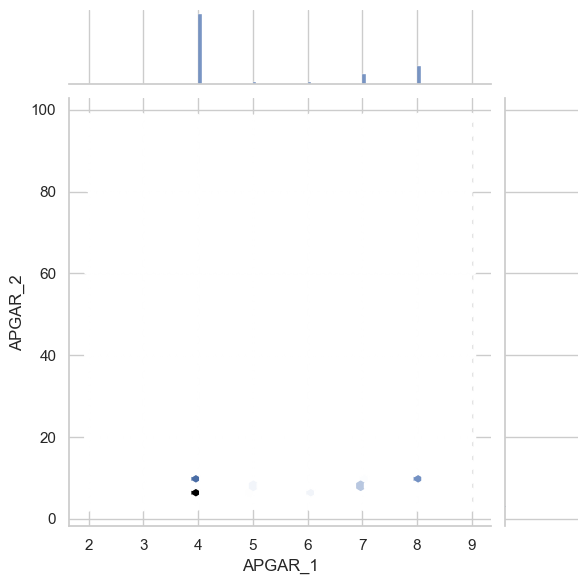

In [20]:
print(merged[['APGAR_1', 'APGAR_2']].describe())
sns.jointplot(x='APGAR_1', y='APGAR_2', data=merged, kind='hex')

<AxesSubplot:>

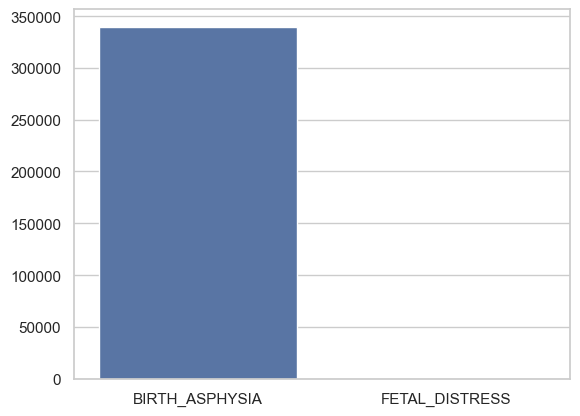

In [19]:
neonatal_comp = merged[['BIRTH_ASPHYSIA', 'FETAL_DISTRESS']]
comp_count = neonatal_comp.sum()
sns.barplot(x=comp_count.index, y=comp_count)